# Balzax environments

***To be run on Collab***

## Imports and modules

### Install Flax

In [3]:
!pip install flax

### Install Balzax

In [4]:
!pip install git+https://github.com/charlypg/Balzax@v_0.0.2

  Cloning https://github.com/charlypg/Balzax (to revision v_0.0.2) to /tmp/pip-req-build-650vrwsj
  Running command git clone -q https://github.com/charlypg/Balzax /tmp/pip-req-build-650vrwsj
  Running command git checkout -b v_0.0.2 --track origin/v_0.0.2
  Switched to a new branch 'v_0.0.2'
  Branch 'v_0.0.2' set up to track remote branch 'v_0.0.2' from 'origin'.


### Imports

In [5]:
import jax
import jax.numpy as jnp
import flax
from functools import partial
import matplotlib.pyplot as plt
from time import time 

from balzax import BallsEnv, BallsEnvGoal

## Devices

In [6]:
print(jax.devices())

[GpuDevice(id=0, process_index=0)]


## Testing vectorized BallEnv

In [7]:
OBS_TYPE = 'image' # @param ['position', 'image']
SEED = 0
NUM_ENV = 3

NB_ITER = 50

ACTION_0 = jnp.zeros((NUM_ENV, 1))
ACTION_1 = jnp.ones((NUM_ENV, 1))/2.

key = jax.random.PRNGKey(SEED)
keys = jax.random.split(key, num=NUM_ENV)

#print(keys)

env = BallsEnv(obs_type=OBS_TYPE)

vmap_env_reset = jax.jit(jax.vmap(env.reset))  # jax.vmap(env.reset)
vmap_env_step = jax.jit(jax.vmap(env.step))  # jax.vmap(env.step)

obs_list = []

print()
print("Observation type : {}".format(OBS_TYPE))
print("Seed : {}".format(SEED))
print("Number of envs : {}".format(NUM_ENV))
print()

t0 = time()
env_states = vmap_env_reset(keys)
print("Time du reset (jit+exec) : {}".format(time()-t0))
print()

#print(env_states)

observations = env_states.obs
print("observations : {}".format(observations.shape))
print()

t0 = time()
env_states = vmap_env_reset(keys)
print("Time du reset (second time exec) : {}".format(time()-t0))
print()

obs_list.append(env_states.obs)

t0 = time()
env_states = vmap_env_step(env_states, ACTION_0)
print("First step (jit+exec) : {}".format(time()-t0))
print()

obs_list.append(env_states.obs)

t0 = time()
env_states = vmap_env_step(env_states, ACTION_1)
print("Second step (exec) : {}".format(time()-t0))
print()

obs_list.append(env_states.obs)

t0 = time()
for _ in range(NB_ITER):
    env_states = vmap_env_step(env_states, ACTION_1)
    obs_list.append(env_states.obs)
print("{0} iterations in {1}s".format(NB_ITER, time()-t0))
print()

pulse = 2*jnp.pi / NB_ITER * jnp.ones((NUM_ENV, 1))
t0 = time()
for i in range(NB_ITER):
    env_states = vmap_env_step(env_states, jnp.sin(pulse*i))
    obs_list.append(env_states.obs)
print("{0} iterations in {1}s".format(NB_ITER, time()-t0))
print()


Observation type : image
Seed : 0
Number of envs : 3

Time du reset (jit+exec) : 17.809800624847412

observations : (3, 224, 224, 1)

Time du reset (second time exec) : 0.0039441585540771484

First step (jit+exec) : 1.3470749855041504

Second step (exec) : 0.001010894775390625

50 iterations in 0.02153491973876953s

50 iterations in 0.2633960247039795s



## Show first environment of first iteration

(224, 224)


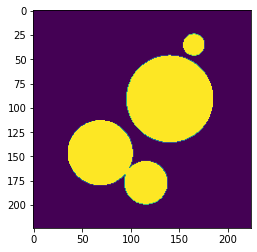

In [8]:
print(obs_list[0][0].squeeze().shape)
plt.imshow(obs_list[0][0].squeeze())

## Generate animation for the rollout

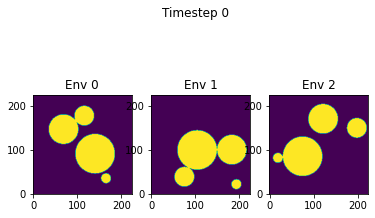

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

def animate(i):
    fig.suptitle('Timestep {}'.format(i))
    ax1.set_title('Env 0')
    ax1.imshow(obs_list[i][0].squeeze(), origin='lower')
    ax2.set_title('Env 1')
    ax2.imshow(obs_list[i][1].squeeze(), origin='lower')
    ax3.set_title('Env 2')
    ax3.imshow(obs_list[i][2].squeeze(), origin='lower')

ani = animation.FuncAnimation(fig, animate, frames=2*NB_ITER)
FFwriter = animation.FFMpegWriter()
ani.save('animation_rollout.mp4', writer=FFwriter)

## Idem in the goal-oriented case

In [10]:
OBS_TYPE = 'image'
SEED = 0
NUM_ENV = 2
MAX_TIMESTEP = 100

NB_ITER_1 = 1
NB_ITER_2 = 200
assert NB_ITER_1 < NB_ITER_2

ACTION_0 = jnp.zeros((NUM_ENV, 1))
ACTION_1 = jnp.ones((NUM_ENV, 1))/2.

key = jax.random.PRNGKey(SEED)
keys = jax.random.split(key, num=NUM_ENV)

env = BallsEnvGoal(obs_type=OBS_TYPE, max_timestep=MAX_TIMESTEP)

vmap_env_reset = jax.jit(jax.vmap(env.reset))
vmap_env_reset_done = jax.jit(jax.vmap(env.reset_done))
vmap_env_step = jax.jit(jax.vmap(env.step))  

goalobs_list = []

print()
print("Observation type : {}".format(OBS_TYPE))
print("Seed : {}".format(SEED))
print("Number of envs : {}".format(NUM_ENV))
print()

t0 = time()
env_states = vmap_env_reset(keys)
print("Time of reset (jit+exec) : {}".format(time()-t0))
print()

for key_goal, value_goal in zip(env_states.goalobs.keys(), 
                                env_states.goalobs.values()):
    print("{0} shape : {1}".format(key_goal, value_goal.shape))
print()

goalobs_list.append(env_states.goalobs)

t0 = time()
env_states = vmap_env_step(env_states, ACTION_0)
print("First step (jit+exec) : {}".format(time()-t0))
print()

goalobs_list.append(env_states.goalobs)

t0 = time()
env_states = vmap_env_step(env_states, ACTION_1)
print("Second step (exec) : {}".format(time()-t0))
print()

goalobs_list.append(env_states.goalobs)

t0 = time()
for _ in range(NB_ITER_1):
    env_states = vmap_env_step(env_states, ACTION_1)
    env_states = vmap_env_reset_done(env_states)
    goalobs_list.append(env_states.goalobs)
print("{0} iterations in {1}s".format(NB_ITER_1, time()-t0))
print()

pulse = 2*jnp.pi / NB_ITER_2 * jnp.ones((NUM_ENV, 1))
t0 = time()
for i in range(NB_ITER_1, NB_ITER_1+NB_ITER_2):
    env_states = vmap_env_step(env_states, jnp.sin(pulse*i))
    env_states = vmap_env_reset_done(env_states)
    goalobs_list.append(env_states.goalobs)
print("{0} iterations in {1}s".format(NB_ITER_2-NB_ITER_1, time()-t0))
print()


Observation type : image
Seed : 0
Number of envs : 2

Time of reset (jit+exec) : 22.743492603302002

achieved_goal shape : (2, 224, 224, 1)
desired_goal shape : (2, 224, 224, 1)
observation shape : (2, 224, 224, 1)

First step (jit+exec) : 1.449892520904541

Second step (exec) : 0.001222848892211914

1 iterations in 25.093971252441406s

199 iterations in 1.2469487190246582s



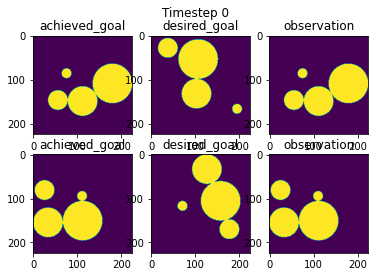

In [11]:
num_goalobs = min(2, NB_ITER_2)
fig, axs = plt.subplots(num_goalobs, 3)
def animate_vect_goalobs(i):
    fig.suptitle('Timestep {}'.format(i))
    for j in range(num_goalobs):
        for k, (field, value) in enumerate(zip(goalobs_list[i].keys(),
                                               goalobs_list[i].values())):
            axs[j,k].imshow(value[j].squeeze())
            axs[j,k].set_title(field)

ani_goal = animation.FuncAnimation(fig, animate_vect_goalobs, frames=NB_ITER_1+NB_ITER_2)
FFwriter = animation.FFMpegWriter()
ani_goal.save('animation_rollout_goal_oriented.mp4', writer=FFwriter)